In [1]:
%reload_ext autoreload
%autoreload 2

import os
import pickle
import logging
import multiprocessing
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp

import arviz as az
import numpyro
import numpyro.distributions as dist

from hbmep.config import Config
from hbmep.model import BaseModel
from hbmep.model.utils import Site as site

PLATFORM = "cpu"
jax.config.update("jax_platforms", PLATFORM)
numpyro.set_platform(PLATFORM)

cpu_count = multiprocessing.cpu_count() - 2
numpyro.set_host_device_count(cpu_count)
numpyro.enable_x64()
numpyro.enable_validation()

logger = logging.getLogger(__name__)


In [2]:
class MixtureModel(BaseModel):
    NAME = "mixture_model"

    def __init__(self, config: Config):
        super(MixtureModel, self).__init__(config=config)
        self.combination_columns = [self.subject] + self.features

    def fn(self, x, a, b, v, L, ell, H):
        return (
            L
            + jnp.where(
                jnp.less(x, a),
                0.,
                -ell + jnp.true_divide(
                    H + ell,
                    jnp.power(
                        1
                        + jnp.multiply(
                            -1
                            + jnp.power(
                                jnp.true_divide(H + ell, ell),
                                v
                            ),
                            jnp.exp(jnp.multiply(-b, x - a))
                        ),
                        jnp.true_divide(1, v)
                    )
                )
            )
        )

    def _model(self, subject, features, intensity, response_obs=None):
        subject, n_subject = subject
        features, n_features = features
        intensity, n_data = intensity

        intensity = intensity.reshape(-1, 1)
        intensity = np.tile(intensity, (1, self.n_response))

        feature0 = features[0].reshape(-1,)
        n_feature0 = n_features[0]

        with numpyro.plate(site.n_response, self.n_response):
            """ Global Priors """
            b_scale_global_scale = numpyro.sample("b_scale_global_scale", dist.HalfNormal(5))
            v_scale_global_scale = numpyro.sample("v_scale_global_scale", dist.HalfNormal(5))

            L_scale_global_scale = numpyro.sample("L_scale_global_scale", dist.HalfNormal(.5))
            ell_scale_global_scale = numpyro.sample("ell_scale_global_scale", dist.HalfNormal(10))
            H_scale_global_scale = numpyro.sample("H_scale_global_scale", dist.HalfNormal(5))

            g_1_scale_global_scale = numpyro.sample("g_1_scale_global_scale", dist.HalfNormal(5))
            g_2_scale_global_scale = numpyro.sample("g_2_scale_global_scale", dist.HalfNormal(5))

            with numpyro.plate("n_feature0", n_feature0):
                """ Hyper-priors """
                a_mean = numpyro.sample("a_mean", dist.TruncatedNormal(50., 20., low=0))
                a_scale = numpyro.sample("a_scale", dist.HalfNormal(30.))

                b_scale_raw = numpyro.sample("b_scale_raw", dist.HalfNormal(scale=1))
                b_scale = numpyro.deterministic("b_scale", jnp.multiply(b_scale_global_scale, b_scale_raw))

                v_scale_raw = numpyro.sample("v_scale_raw", dist.HalfNormal(scale=1))
                v_scale = numpyro.deterministic("v_scale", jnp.multiply(v_scale_global_scale, v_scale_raw))

                L_scale_raw = numpyro.sample("L_scale_raw", dist.HalfNormal(scale=1))
                L_scale = numpyro.deterministic("L_scale", jnp.multiply(L_scale_global_scale, L_scale_raw))

                ell_scale_raw = numpyro.sample("ell_scale_raw", dist.HalfNormal(scale=1))
                ell_scale = numpyro.deterministic("ell_scale", jnp.multiply(ell_scale_global_scale, ell_scale_raw))

                H_scale_raw = numpyro.sample("H_scale_raw", dist.HalfNormal(scale=1))
                H_scale = numpyro.deterministic("H_scale", jnp.multiply(H_scale_global_scale, H_scale_raw))

                g_1_scale_raw = numpyro.sample("g_1_scale_raw", dist.HalfNormal(scale=1))
                g_1_scale = numpyro.deterministic("g_1_scale", jnp.multiply(g_1_scale_global_scale, g_1_scale_raw))

                g_2_scale_raw = numpyro.sample("g_2_scale_raw", dist.HalfNormal(scale=1))
                g_2_scale = numpyro.deterministic("g_2_scale", jnp.multiply(g_2_scale_global_scale, g_2_scale_raw))

                with numpyro.plate(site.n_subject, n_subject):
                    """ Priors """
                    a = numpyro.sample(
                        site.a, dist.TruncatedNormal(a_mean, a_scale, low=0)
                    )

                    b_raw = numpyro.sample("b_raw", dist.HalfNormal(scale=1))
                    b = numpyro.deterministic(site.b, jnp.multiply(b_scale, b_raw))

                    v_raw = numpyro.sample("v_raw", dist.HalfNormal(scale=1))
                    v = numpyro.deterministic(site.v, jnp.multiply(v_scale, v_raw))

                    L_raw = numpyro.sample("L_raw", dist.HalfNormal(scale=1))
                    L = numpyro.deterministic(site.L, jnp.multiply(L_scale, L_raw))

                    ell_raw = numpyro.sample("ell_raw", dist.HalfNormal(scale=1))
                    ell = numpyro.deterministic(site.ell, jnp.multiply(ell_scale, ell_raw))

                    H_raw = numpyro.sample("H_raw", dist.HalfNormal(scale=1))
                    H = numpyro.deterministic(site.H, jnp.multiply(H_scale, H_raw))

                    g_1_raw = numpyro.sample("g_1_raw", dist.HalfCauchy(scale=1))
                    g_1 = numpyro.deterministic(site.g_1, jnp.multiply(g_1_scale, g_1_raw))

                    g_2_raw = numpyro.sample("g_2_raw", dist.HalfCauchy(scale=1))
                    g_2 = numpyro.deterministic(site.g_2, jnp.multiply(g_2_scale, g_2_raw))

                    """ Penalty """
                    # penalty_for_small_a_and_small_b = (
                    #     jnp.true_divide(1, a) + jnp.true_divide(1, b)
                    # )
                    # numpyro.factor("penalty_for_small_a_and_small_b", -penalty_for_small_a_and_small_b)

                    # penalty_for_small_a_and_small_b = (
                    #     jnp.true_divide(1, a + b)
                    # )
                    # numpyro.factor("penalty_for_small_a_and_small_b", -penalty_for_small_a_and_small_b)

                    """ Penalty """
                    penalty = (
                        jnp.true_divide(1, jnp.power(b, 2) + jnp.power(H, 2))
                    )
                    numpyro.factor("penalty", -penalty)

        """ Outlier Distribution """
        outlier_prob = numpyro.sample("outlier_prob", dist.Uniform(0., .01))
        outlier_scale = numpyro.sample("outlier_scale", dist.HalfNormal(10))

        with numpyro.plate(site.n_response, self.n_response):
            with numpyro.plate(site.n_data, n_data):
                """ Model """
                mu = numpyro.deterministic(
                    site.mu,
                    self.fn(
                        x=intensity,
                        a=a[subject, feature0],
                        b=b[subject, feature0],
                        v=v[subject, feature0],
                        L=L[subject, feature0],
                        ell=ell[subject, feature0],
                        H=H[subject, feature0]
                    )
                )
                beta = numpyro.deterministic(
                    site.beta,
                    g_1[subject, feature0] + jnp.true_divide(g_2[subject, feature0], mu)
                )

                q = numpyro.deterministic("q", outlier_prob * jnp.ones((n_data, self.n_response)))
                bg_scale = numpyro.deterministic("bg_scale", outlier_scale * jnp.ones((n_data, self.n_response)))

                mixing_distribution = dist.Categorical(
                    probs=jnp.stack([1 - q, q], axis=-1)
                )
                component_distributions=[
                    dist.Gamma(concentration=jnp.multiply(mu, beta), rate=beta),
                    dist.HalfNormal(scale=bg_scale)
                ]

                """ Mixture """
                Mixture = dist.MixtureGeneral(
                    mixing_distribution=mixing_distribution,
                    component_distributions=component_distributions
                )

                """ Observation """
                numpyro.sample(
                    site.obs,
                    Mixture,
                    obs=response_obs
                )


In [3]:
toml_path = "/home/vishu/repos/hbmep-paper/configs/paper/tms/config.toml"
config = Config(toml_path=toml_path)
config.BUILD_DIR = os.path.join(config.BUILD_DIR, "group-comparison", "fix-3")
config.RESPONSE = ["PKPK_APB"]
config.MCMC_PARAMS["num_warmup"] = 4000
config.MCMC_PARAMS["num_samples"] = 1000

model = MixtureModel(config=config)


2023-12-04 15:28:18,208 - hbmep.model.baseline - INFO - Initialized mixture_model


In [4]:
src = "/home/vishu/data/hbmep-processed/human/tms/proc_2023-11-28.csv"
df = pd.read_csv(src)

df[model.features[0]] = \
    df[model.features[0]].replace({
        "Uninjured": "01_Uninjured",
        "Injured": "02_Injured"
    })

subset = ["SCA01", "SCS02"]
ind = df[model.subject].isin(subset)
df = df[ind].reset_index(drop=True).copy()

df, encoder_dict = model.load(df=df)


2023-12-04 15:28:18,285 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/paper/tms/group-comparison/fix
2023-12-04 15:28:18,286 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbmep-paper/reports/paper/tms/group-comparison/fix
2023-12-04 15:28:18,287 - hbmep.dataset.core - WARNING - Total non-positive observations: 0
2023-12-04 15:28:18,288 - hbmep.dataset.core - WARNING - Total missing observations: 0
2023-12-04 15:28:18,288 - hbmep.dataset.core - INFO - Processing data ...
2023-12-04 15:28:18,290 - hbmep.utils.utils - INFO - func:load took: 0.00 sec


In [5]:
mcmc, posterior_samples = model.run_inference(df=df)


2023-12-04 15:28:18,371 - hbmep.model.baseline - INFO - Running inference with mixture_model ...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

2023-12-04 15:29:39,148 - hbmep.utils.utils - INFO - func:run_inference took: 1 min and 20.78 sec


In [6]:
_posterior_samples = posterior_samples.copy()
_posterior_samples["outlier_prob"] = 0 * _posterior_samples["outlier_prob"]
prediction_df = model.make_prediction_dataset(df=df)
posterior_predictive = model.predict(df=prediction_df, posterior_samples=_posterior_samples)
model.render_recruitment_curves(df=df, encoder_dict=encoder_dict, posterior_samples=_posterior_samples, prediction_df=prediction_df, posterior_predictive=posterior_predictive)
model.render_predictive_check(df=df, encoder_dict=encoder_dict, prediction_df=prediction_df, posterior_predictive=posterior_predictive)


2023-12-04 15:29:39,230 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.01 sec


2023-12-04 15:29:40,663 - hbmep.utils.utils - INFO - func:predict took: 1.43 sec
2023-12-04 15:29:40,664 - hbmep.model.baseline - INFO - Rendering recruitment curves ...
2023-12-04 15:29:41,193 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/paper/tms/group-comparison/fix/recruitment_curves.pdf
2023-12-04 15:29:41,194 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 0.53 sec
2023-12-04 15:29:41,194 - hbmep.model.baseline - INFO - Rendering posterior predictive checks ...
2023-12-04 15:29:41,760 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/paper/tms/group-comparison/fix/posterior_predictive_check.pdf
2023-12-04 15:29:41,761 - hbmep.utils.utils - INFO - func:predictive_checks_renderer took: 0.57 sec
2023-12-04 15:29:41,761 - hbmep.utils.utils - INFO - func:render_predictive_check took: 0.57 sec


In [ ]:
a_mean = posterior_samples["a_mean"]
a_mean.shape


(4000, 2, 1)

In [ ]:
samples = a_mean[:, 1, 0] - a_mean[:, 0, 0]
(samples > 0).mean()

0.89275

<Axes: ylabel='Density'>

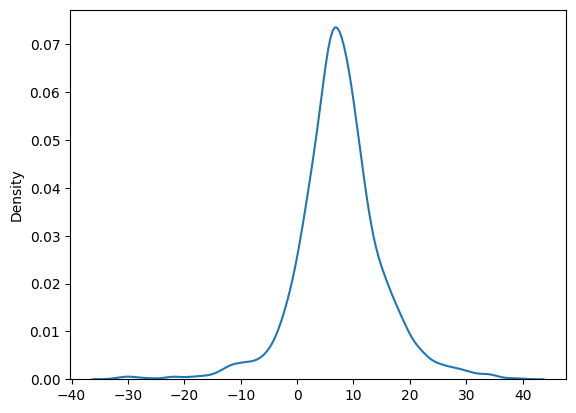

In [ ]:
import seaborn as sns
sns.kdeplot(samples)


In [ ]:
dest = os.path.join(model.build_dir, "inference.pkl")
with open(dest, "wb") as f:
    pickle.dump((model, mcmc, posterior_samples), f)

print(dest)


/home/vishu/repos/hbmep-paper/reports/paper/tms/experiments/sparse-subjects/learn-posterior/inference.pkl


In [ ]:
dest = os.path.join(model.build_dir, "inference.nc")
az.to_netcdf(mcmc, dest)
dest


'/home/vishu/repos/hbmep-paper/reports/paper/tms/experiments/sparse-subjects/learn-posterior/inference.nc'

In [ ]:
numpyro_data = az.from_numpyro(mcmc)

""" Model evaluation """
logger.info("Evaluating model ...")

score = az.loo(numpyro_data, var_name=site.obs)
logger.info(f"ELPD LOO (Log): {score.elpd_loo:.2f}")

score = az.waic(numpyro_data, var_name=site.obs)
logger.info(f"ELPD WAIC (Log): {score.elpd_waic:.2f}")


2023-11-22 15:19:21,862 - __main__ - INFO - Evaluating model ...
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
2023-11-22 15:19:26,560 - __main__ - INFO - ELPD LOO (Log): 1490.21
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities